In [ ]:
# MIT License
#
# Copyright (c) 2020 Fagner Cunha
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Redes Neurais Convolutivas com TensorFlow

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/alcunha/nn-with-tf/blob/master/Convolutional-Neural-Networks-with-TF.ipynb"><img src="./images/colab_logo_32px.png" />Executar no Google Colab</a>
  </td>
  <td>
    <a href="https://github.com/alcunha/nn-with-tf/blob/master/Convolutional-Neural-Networks-with-TF.ipynb"><img src="./images/GitHub-Mark-32px.png" />Ver código no GitHub</a>
  </td>
</table>

*“NÃO ENTRE EM PÂNICO”*

(O Guia do Mochileiro das Galáxias)

In [ ]:
! pip install tensorflow tensorflow_datasets tfds-nightly matplotlib

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Redes Convolutivas

Redes neurais convolutivas são um subtipo especial de rede neural 
*feedfoward* especializado no processamento de dados organizados em 
topologia similar a uma grade [1]. O exemplo clássico 
desse tipo de dado são as imagens, as quais são organizadas em topologia 2D.

Os principais tipos de camadas utilizados em uma rede convolutiva são as camadas 
convolutivas, as camadas de *pooling* e as camadas completamente conectadas. Porém
as redes modernas utilizam uma série de outros tipos de camadas como as camadas de
*batch normalization* e de *skip*.

### Camada convolutiva

Cada unidade de uma camada convolutiva está conectada somente a um conjunto de campos receptivos 
locais, em vez de todas as unidades da camada anterior, como ocorre nas camadas 
completamente conectadas. Além disso, essas unidades são organizadas em mapas
de filtros, onde as unidades de cada mapa compartilham os mesmos pesos.

<img src="./images/conv_kernel.gif" width="600">
<center>Figura 1: Exemplo de operação de convolução com um filtro 3x3</center>
<center>Fonte: [2]</center>

In [2]:
input_value = tf.constant([
    [60, 113, 56, 139, 85],
    [73, 121, 54, 84, 128],
    [131, 99, 70, 129, 127],
    [80, 57, 115, 69, 134],
    [104, 126, 123, 95, 130]
], shape=(1, 5, 5, 1), dtype=tf.float32)

In [3]:
kernel = tf.constant([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
], shape=(3, 3, 1, 1), dtype=tf.float32)

In [4]:
tf.nn.conv2d(input_value, kernel, strides=1, padding='SAME')

<tf.Tensor: shape=(1, 5, 5, 1), dtype=float32, numpy=
array([[[[ 114.],
         [ 328.],
         [ -26.],
         [ 470.],
         [ 158.]],

        [[  53.],
         [ 266.],
         [ -61.],
         [ -30.],
         [ 344.]],

        [[ 403.],
         [ 116.],
         [ -47.],
         [ 295.],
         [ 244.]],

        [[ 108.],
         [-135.],
         [ 256.],
         [-128.],
         [ 344.]],

        [[ 314.],
         [ 346.],
         [ 279.],
         [ 153.],
         [ 421.]]]], dtype=float32)>

##### Stride

Stride é a quantidade de posições a serem movidas a cada nova aplicação do filtro sobre a entrada (e em cada um dos eixos). A Figura 1 apresenta stride de (1, 1), ou seja a cada vez que o filtro é aplicado à entrada move-se uma posição em relação à entrada. A Figura 2 apresenta uma animação de com stride de (2,2).

<img src="./images/padding_strides.gif" width="250">
<center>Figura 2: Animação de um filtro 3x3 com stride de (2,2)</center>
<center>Fonte: [3]</center>

In [5]:
tf.nn.conv2d(input_value, kernel, strides=2, padding='SAME')

<tf.Tensor: shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[114.],
         [-26.],
         [158.]],

        [[403.],
         [-47.],
         [244.]],

        [[314.],
         [279.],
         [421.]]]], dtype=float32)>

##### Padding

Por padrão, a operação de convolução começa com o filtro alinhado com o pixel da primeira linha e primeira coluna. Dessa forma, os pixels das bordas acabam passando por menos operações. *Padding* é quando se opta por adicionar zeros ao redor da imagem ao aplicar o filtro convolutivo.

O tamanho do *padding* pode ser arbitrário, mas geralmente os frameworks possuem as opções "VALID" (sem padding) e "SAME", onde o tamanho do padding é calculado de forma que a saída tenha o mesmo tamanho da entrada. A Figura 1 apresenta um exemplo de padding "SAME" e a Figura 3 apresenta uma animação com padding "VALID". 


<img src="./images/no_padding_no_strides.gif" width="250">
<center>Figura 3: Animação de um filtro 3x3 com padding "VALID"</center>
<center>Fonte: [3]</center>

In [6]:
tf.nn.conv2d(input_value, kernel, strides=1, padding='VALID')

<tf.Tensor: shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[ 266.],
         [ -61.],
         [ -30.]],

        [[ 116.],
         [ -47.],
         [ 295.]],

        [[-135.],
         [ 256.],
         [-128.]]]], dtype=float32)>

### Camada de *pooling*

Camadas de pooling funcionam fazendo sub-amostragem da representação recebida,
juntando características semanticamente similares em uma só.

O max pooling calcula o valor máximo de um conjunto local de unidades de um determinado mapa de filtros.
Outra operação comum nesse tipo de camada é o cálculo da média do conjunto local (average pooling).

In [7]:
input_value_2 = tf.constant([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16],
], shape=(1, 4, 4, 1), dtype=tf.float32)

In [8]:
tf.nn.max_pool2d(input_value_2, ksize=(2,2), strides=2, padding='VALID')

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[ 6.],
         [ 8.]],

        [[14.],
         [16.]]]], dtype=float32)>

In [9]:
tf.nn.avg_pool2d(input_value_2, ksize=(2,2), strides=2, padding='VALID')

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[ 3.5],
         [ 5.5]],

        [[11.5],
         [13.5]]]], dtype=float32)>

## Exemplo Prático: CNN para o dataset Fashion MNIST

1. Utilização do TensorFlow Datasets
2. Preparação do pipeline de dados
3. Construção do modelo
4. Treinamento
5. Avaliação do modelo e visualização dos resultados

O MNIST [4] é uma base de digitos numéricos manuscritos composta por imagens em escala de cinza de tamanho 28 x 28. O Fashion MNIST [5] é uma base que segue o mesmo formato da MNIST, porém, em vez de dígitos, as 10 categorias são produtos de moda. 

In [10]:
def tuple2dict(image, label):
    sample_dict = {
        'image': image,
        'label': label
    }
    return sample_dict

def show_examples(dataset, info):
    dataset = dataset.map(tuple2dict, num_parallel_calls=AUTOTUNE)
    tfds.show_examples(dataset, info, rows=2, cols=4)
    plt.close()

Carregando o dataset disponibilizado pela biblioteca TensorFloaw Datasets:

In [11]:
(fmnist_train, fmnist_test), info = tfds.load('fashion_mnist',
                                              split=['train', 'test'],
                                              shuffle_files=True,
                                              as_supervised=True,
                                              with_info=True)

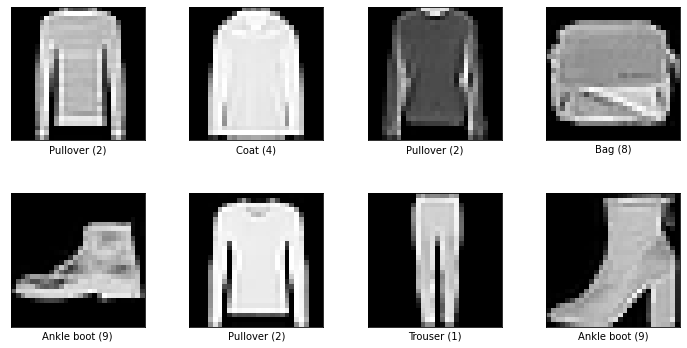

In [12]:
show_examples(fmnist_train, info)

#### Explorando os metadados do dataset carregados utilizando a opção with_info:

In [13]:
print(info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [14]:
print(info.features['image'])

Image(shape=(28, 28, 1), dtype=tf.uint8)


In [15]:
print(info.features["label"].names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [16]:
print(info.features["label"].num_classes)

10


#### Explorando os dados:

In [17]:
image, label = next(iter(fmnist_train))

In [18]:
image.numpy()

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

In [19]:
label.numpy()

2

In [20]:
info.features['label'].int2str(label.numpy())

'Pullover'

#### Preparando o pipeline de dados

In [21]:
TRAIN_LENGHT = info.splits['train'].num_examples
TEST_LENGHT = info.splits['test'].num_examples
NUM_CLASSES = info.features['label'].num_classes

In [22]:
EPOCHS = 10
BATCH_SIZE = 128

In [23]:
def apply_agumentation(image, label):
    image = tf.image.random_flip_left_right(image)
    
    return image, label

In [24]:
fmnist_train = fmnist_train.map(apply_agumentation, num_parallel_calls=AUTOTUNE)
fmnist_train = fmnist_train.shuffle(buffer_size=TRAIN_LENGHT)
fmnist_train = fmnist_train.batch(BATCH_SIZE, drop_remainder=True)
fmnist_train = fmnist_train.prefetch(buffer_size=AUTOTUNE)

In [25]:
images, labels = next(iter(fmnist_train))

In [26]:
images.shape

TensorShape([128, 28, 28, 1])

In [27]:
labels.shape

TensorShape([128])

In [28]:
labels

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([4, 3, 4, 3, 2, 8, 0, 1, 6, 6, 9, 6, 9, 5, 9, 0, 2, 1, 3, 0, 6, 7,
       4, 5, 3, 0, 8, 8, 1, 0, 5, 7, 9, 4, 3, 7, 2, 4, 1, 5, 9, 8, 7, 1,
       6, 3, 9, 5, 2, 0, 2, 6, 7, 6, 8, 3, 9, 6, 7, 5, 1, 6, 7, 1, 7, 1,
       3, 4, 5, 4, 2, 9, 6, 4, 7, 2, 3, 6, 3, 9, 1, 6, 6, 5, 9, 9, 0, 3,
       6, 4, 1, 0, 9, 3, 1, 8, 1, 1, 0, 3, 4, 4, 3, 4, 1, 8, 6, 9, 1, 3,
       1, 6, 1, 9, 7, 7, 1, 6, 0, 9, 7, 3, 8, 9, 7, 2, 1, 1])>

No teste não precisamos aleatorizar as instâncias:

In [29]:
fmnist_test = fmnist_test.batch(BATCH_SIZE, drop_remainder=True)
fmnist_test = fmnist_test.prefetch(buffer_size=AUTOTUNE)

### Construindo o modelo

In [30]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         7

Como os nossos rótulos são inteiros, utilizamos a função de loss SparseCategoricalCrossentropy. Se quisermos utilizar o formato one-hot, deve-se trocar a função de loss por CategoricalCrossentropy:

In [32]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

### Treinamento

In [33]:
history = model.fit(fmnist_train,
                      epochs=EPOCHS,
                      validation_data=fmnist_test,
                      validation_steps=TEST_LENGHT // BATCH_SIZE)

Epoch 1/10
468/468 [==============================] - 3s 7ms/step - loss: 0.4858 - accuracy: 0.8313 - val_loss: 0.4701 - val_accuracy: 0.8380
Epoch 2/10
468/468 [==============================] - 3s 6ms/step - loss: 0.2891 - accuracy: 0.8960 - val_loss: 0.3114 - val_accuracy: 0.8880
Epoch 3/10
468/468 [==============================] - 3s 7ms/step - loss: 0.2457 - accuracy: 0.9112 - val_loss: 0.3413 - val_accuracy: 0.8756
Epoch 4/10
468/468 [==============================] - 3s 6ms/step - loss: 0.2210 - accuracy: 0.9201 - val_loss: 0.2886 - val_accuracy: 0.8928
Epoch 5/10
468/468 [==============================] - 3s 6ms/step - loss: 0.2060 - accuracy: 0.9245 - val_loss: 0.2853 - val_accuracy: 0.8977
Epoch 6/10
468/468 [==============================] - 3s 7ms/step - loss: 0.1942 - accuracy: 0.9281 - val_loss: 0.2471 - val_accuracy: 0.9109
Epoch 7/10
468/468 [==============================] - 3s 7ms/step - loss: 0.1827 - accuracy: 0.9332 - val_loss: 0.3391 - val_accuracy: 0.8828
Epoch 

### Resultados

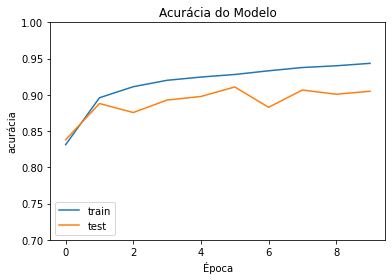

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.7, 1])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

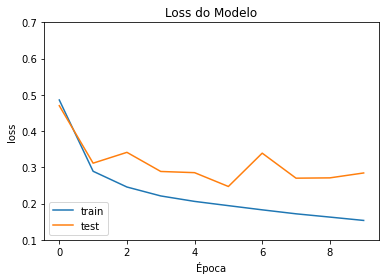

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.1, 0.7])
plt.title('Loss do Modelo')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

### Predição

In [36]:
def format_label(label):
    return info.features['label'].int2str(label)

In [37]:
features, labels = next(iter(fmnist_test))

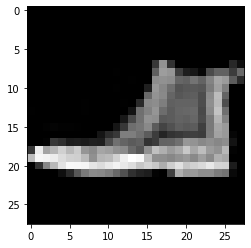

In [38]:
plt.imshow(features.numpy()[0].reshape(28, 28), cmap='gray')

In [39]:
info.features['label'].int2str(labels.numpy()[0])

'Ankle boot'

In [40]:
predictions = model.predict(features.numpy())

In [41]:
predictions[0]

array([-4.7604313 , -5.609596  , -6.2422547 , -3.555223  , -7.353157  ,
       -0.99748856, -6.4262013 ,  1.3477979 , -2.0708833 ,  4.681302  ],
      dtype=float32)

In [42]:
for pred, label in zip(predictions, labels.numpy()):
    print("Predição: {}, Real: {}".format(format_label(tf.argmax(pred).numpy()),
                                        format_label(label)))

Predição: Ankle boot, Real: Ankle boot
Predição: Coat, Real: Coat
Predição: Coat, Real: Coat
Predição: Sneaker, Real: Sneaker
Predição: Sandal, Real: Sandal
Predição: Trouser, Real: Trouser
Predição: T-shirt/top, Real: T-shirt/top
Predição: Sandal, Real: Sandal
Predição: Sneaker, Real: Sneaker
Predição: Coat, Real: Coat
Predição: Bag, Real: Bag
Predição: Pullover, Real: Pullover
Predição: Sneaker, Real: Sneaker
Predição: T-shirt/top, Real: T-shirt/top
Predição: Dress, Real: Dress
Predição: Ankle boot, Real: Ankle boot
Predição: T-shirt/top, Real: T-shirt/top
Predição: Sneaker, Real: Sneaker
Predição: Pullover, Real: Pullover
Predição: Pullover, Real: Pullover
Predição: T-shirt/top, Real: T-shirt/top
Predição: Coat, Real: Coat
Predição: Coat, Real: Coat
Predição: T-shirt/top, Real: Pullover
Predição: Sandal, Real: Sandal
Predição: Coat, Real: Coat
Predição: Sneaker, Real: Sneaker
Predição: Sneaker, Real: Sneaker
Predição: Coat, Real: Coat
Predição: Pullover, Real: Pullover
Predição: Pul

### Referências

[1] Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016.

[2] How to plot an animated matrix in matplotlib. StackOverflow. Disponível em: https://stackoverflow.com/questions/52067833/how-to-plot-an-animated-matrix-in-matplotlib . Acesso em: 09 de julho de 2020

[3] Dumoulin, Vincent, and Francesco Visin. "A guide to convolution arithmetic for deep learning." arXiv preprint arXiv:1603.07285 (2016).

[4] LeCun, Yann, Corinna Cortes, and C. J. Burges. "MNIST handwritten digit database." (2010): 18.

[5] Xiao, Han, Kashif Rasul, and Roland Vollgraf. "Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms." arXiv preprint arXiv:1708.07747 (2017).